In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import visual_behavior.utilities as vbu
from sync import Dataset

from allensdk.internal.brain_observatory.time_sync import get_photodiode_events

In [262]:
%matplotlib notebook

## load data from Kat (which I saved as txt file)

In [263]:
with open('sessions_to_troubleshoot.txt') as f:
    data = ast.literal_eval(f.read())

## clean strings, make dataframe

In [264]:
additional_sessions = [
    {
        'exp_id':1013205924,
        'output_json_path':'/allen/programs/braintv/production/neuralcoding/prod55/specimen_999264430/ophys_session_1013163234/ophys_experiment_1013205924/1013205924_time_synchronization_output.json',
        'in_json_path':'/allen/programs/braintv/production/neuralcoding/prod55/specimen_999264430/ophys_session_1013163234/ophys_experiment_1013205924/1013205924_ophys_time_synchronization_input.json'
    },
    {
        'exp_id':1001535125,
        'output_json_path':'/allen/programs/braintv/production/visualbehavior/prod4/specimen_951667115/ophys_session_1001381149/ophys_experiment_1001535125/1001535125_time_synchronization_output.json',
        'in_json_path':'/allen/programs/braintv/production/visualbehavior/prod4/specimen_951667115/ophys_session_1001381149/ophys_experiment_1001535125/1001535125_ophys_time_synchronization_input.json'
    },
]

In [265]:
def clean(string):
    if type(string) == str:
        return string.replace('\\','')

session_df = pd.concat((pd.DataFrame(data),pd.DataFrame(additional_sessions)))

for col in ['output_json_path','in_json_path']:
    session_df[col] = session_df[col].map(lambda s:clean(s))
    
session_df.tail()

,exp_id,output_json_path,in_json_path
14,1009114207,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/visualbehav...
15,1010810523,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/visualbehav...
16,1010064301,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/visualbehav...
0,1013205924,/allen/programs/braintv/production/neuralcodin...,/allen/programs/braintv/production/neuralcodin...
1,1001535125,/allen/programs/braintv/production/visualbehav...,/allen/programs/braintv/production/visualbehav...


## some functions

In [266]:
def load_output_json(session):
    with open(session['output_json_path']) as f:
        output_json = json.load(f)
    return output_json

def load_sync_data(session):
    with open(session['in_json_path']) as f:
        input_json = json.load(f)
    return Dataset(input_json['sync_file'])

def extract_from_sync(session):
    '''load sync data from file, extract vysyncs and photodiode events'''
    
    sync_data = load_sync_data(session)
    
    sample_freq = sync_data.meta_data['ni_daq']['counter_output_freq']
    line_labels = [label for label in sync_data.meta_data['line_labels'] if label != '']
    
    sync_vsync_times = sync_data.get_falling_edges('stim_vsync')/sample_freq
    
    photodiode_risetimes = sync_data.get_rising_edges('stim_photodiode')/sample_freq
    photodiode_falltimes = sync_data.get_falling_edges('stim_photodiode')/sample_freq
    photodiode_all = np.sort(np.hstack((photodiode_risetimes,photodiode_falltimes)))
    
#     photodiode_all = get_photodiode_events(load_sync_data(session), 'stim_photodiode')
    
    return sync_vsync_times, photodiode_all

In [267]:
def calculate_lag(sync_vsync_times, photodiode_all, first_valid_pd):
    '''calculate lag, assuming that photodiode events before `first_valid_pd` should be ignored'''
    lag = np.empty(len(sync_vsync_times[::60]))
    key_frames = sync_vsync_times[::60]
    for idx,key_frame in enumerate(key_frames):
        lag[idx]=photodiode_all[first_valid_pd:][idx]-key_frame
    return lag

def get_lags_at_all_pd_starts(sync_vsync_times, photodiode_all):
    '''calculate lag at a range of first valid pd values'''
    pd_start_df = []
    for first_valid_pd in range(10):
        lag = calculate_lag(sync_vsync_times, photodiode_all, first_valid_pd)
        this_entry = dict(pd.Series(lag).describe())
        this_entry.update({'first_valid_pd':first_valid_pd})
        pd_start_df.append(this_entry)
    return pd.DataFrame(pd_start_df)

In [268]:
def plot_sync_data(session_id, sync_vsync_times, photodiode_all, first_valid_pd_index):
    '''plot vysncs, pd events, and calculated lag for a given first_valid_pd_event'''
    fig,ax=plt.subplots(3,1,sharex=True,figsize=(8,6))
    # plot photodiode diffs
    ax[0].plot(photodiode_all[1:],np.diff(photodiode_all),marker='.')

    ax[0].set_ylabel('interval between\nphotodiode state changes (s)')

    # plot vsync diffs
    ax[1].plot(sync_vsync_times[1:],np.diff(sync_vsync_times))
    ax[1].set_ylabel('interval between\nstim frames(s)')
    
    # plot lag between every pd event and every 60th vsync 
    lag = calculate_lag(sync_vsync_times, photodiode_all,first_valid_pd_index)
    ax[2].plot(sync_vsync_times[::60],lag)

    ax[2].set_xlabel('session time (s)')
    ax[2].set_ylabel('calculated lag (s)')
    ax[2].axhline(np.mean(lag),color='r')
    ax[2].text(0,np.mean(lag)+0.0005,'mean display lag = {:.3f} ms'.format(1000*np.mean(lag)),color='r')
    
    ax[2].plot(sync_vsync_times[::60],lag)

    ax[2].set_xlabel('session time (s)')
    ax[2].set_ylabel('calculated lag (s)')
    ax[2].axhline(np.mean(lag),color='r')
    ax[2].text(0,np.mean(lag)+0.0005,'mean display lag = {:.3f} ms'.format(1000*np.mean(lag)),color='r')
    ax[2].set_title('calculated assuming the first valid photdiode number was {}'.format(first_valid_pd_index))

    fig.suptitle('session_id = {}'.format(session_id))
    
    return fig

In [270]:
print('number of pd pulses to cut off at beginning: {}'.format(optimal_first_pd))
print(photodiode_all[optimal_first_pd:optimal_first_pd+5])
print(photodiode_all[-13:-7])
print(photodiode_all[-7:])

number of pd pulses to cut off at beginning: 9
[ 6.00474  7.00329  8.00632  9.00491 10.00796]
[4501.70508 4502.70367 4503.70668 4504.70528 4505.70834 4506.70692]
[4506.94266 4507.02384 4507.1095  4507.19065 4507.27627 4507.35745
 4507.45966]


In [271]:
len(photodiode_all[first_idx:last_idx+2])

4498

In [232]:
lag_summary = []
for idx,session in session_df.iterrows():
    sync_vsync_times, photodiode_all = extract_from_sync(session)
    camstim_pd_events = get_photodiode_events(load_sync_data(session), 'stim_photodiode')
    
    pd_df = get_lags_at_all_pd_starts(sync_vsync_times, photodiode_all)
    optimal_first_pd = pd_df['first_valid_pd'].loc[pd_df['std'].argmin()]
    
    first_idx = np.where(photodiode_all == camstim_pd_events[0])[0][0]
    last_idx = np.where(photodiode_all == camstim_pd_events[-1])[0][0]
    missing_interval = photodiode_all[last_idx+1] - photodiode_all[last_idx]
    
    lag = calculate_lag(sync_vsync_times, photodiode_all[first_idx:last_idx+2], first_valid_pd=0)
    
    this_entry = dict(pd.Series(lag).describe())
    this_entry.update({'exp_id':session['exp_id']})
    lag_summary.append(this_entry)
    
    print('exp_id: {}'.format(session['exp_id']))
    print('='*20)
    
    
    print('\tlen(sync_vsync_times[::60]): {}'.format(len(sync_vsync_times[::60])))

    
    actual_pd_events = len(camstim_pd_events)
    print('\tactual number of photodiode events (rising and falling): {}'.format(actual_pd_events))
    print('\tinterval to first cut-off PD event: {}'.format(missing_interval))
    print('')


exp_id: 1004405232
	len(sync_vsync_times[::60]): 4498
	actual number of photodiode events (rising and falling): 4497
	interval to first cut-off PD event: 1.003299999999399

exp_id: 1004889552
	len(sync_vsync_times[::60]): 4498
	actual number of photodiode events (rising and falling): 4497
	interval to first cut-off PD event: 1.003179999999702

exp_id: 1002314807
	len(sync_vsync_times[::60]): 4498
	actual number of photodiode events (rising and falling): 4497
	interval to first cut-off PD event: 0.9986400000007052

exp_id: 1002576619
	len(sync_vsync_times[::60]): 4504
	actual number of photodiode events (rising and falling): 4503
	interval to first cut-off PD event: 0.9985900000001493

exp_id: 1003122317
	len(sync_vsync_times[::60]): 4502
	actual number of photodiode events (rising and falling): 4501
	interval to first cut-off PD event: 0.9986100000005536

exp_id: 1003456278
	len(sync_vsync_times[::60]): 4500
	actual number of photodiode events (rising and falling): 4499
	interval to fi

In [234]:
pd.DataFrame(lag_summary).set_index('exp_id')

,count,mean,std,min,25%,50%,75%,max
exp_id,,,,,,,,
1004405232,4498.0,0.021235,0.001244,0.01955,0.02001,0.020985,0.02249,0.02260
1004889552,4498.0,0.021203,0.001195,0.01948,0.02003,0.020990,0.02242,0.02253
1002314807,4498.0,0.021507,0.001118,0.01986,0.02043,0.021320,0.02265,0.02275
1002576619,4504.0,0.021512,0.001114,0.01982,0.02043,0.021275,0.02265,0.02276
1003122317,4502.0,0.021516,0.001094,0.01994,0.02043,0.021270,0.02266,0.02274
1003456278,4500.0,0.021540,0.001124,0.01990,0.02045,0.021310,0.02268,0.02282
1006270853,4498.0,0.021205,0.001183,0.01947,0.02004,0.020965,0.02239,0.02261
1003771765,4504.0,0.021533,0.001123,0.01983,0.02044,0.021335,0.02269,0.02280
1004136916,4502.0,0.021233,0.001229,0.01946,0.02002,0.021005,0.02247,0.02258


In [286]:
session_id = 1013205924
session = session_df.query('exp_id == @session_id').iloc[0]
session

exp_id                                                     1013205924
output_json_path    /allen/programs/braintv/production/neuralcodin...
in_json_path        /allen/programs/braintv/production/neuralcodin...
Name: 0, dtype: object

In [287]:
sync_vsync_times, photodiode_all = extract_from_sync(session)
camstim_pd_events = get_photodiode_events(load_sync_data(session), 'stim_photodiode')

pd_df = get_lags_at_all_pd_starts(sync_vsync_times, photodiode_all)
optimal_first_pd = pd_df['first_valid_pd'].loc[pd_df['std'].argmin()]

first_idx = np.where(photodiode_all == camstim_pd_events[0])[0][0]
last_idx = np.where(photodiode_all == camstim_pd_events[-1])[0][0]
missing_interval = photodiode_all[last_idx+1] - photodiode_all[last_idx]

lag = calculate_lag(sync_vsync_times, photodiode_all[first_idx:last_idx+2], first_valid_pd=0)

print('exp_id: {}'.format(session['exp_id']))
print('='*20)


print('\tlen(sync_vsync_times[::60]): {}'.format(len(sync_vsync_times[::60])))


actual_pd_events = len(camstim_pd_events)
print('\tactual number of photodiode events (rising and falling): {}'.format(actual_pd_events))
print('\tinterval to first cut-off PD event: {}'.format(missing_interval))
print('')

exp_id: 1013205924
	len(sync_vsync_times[::60]): 3952
	actual number of photodiode events (rising and falling): 3957
	interval to first cut-off PD event: 0.08312999999998283



In [304]:
lag = calculate_lag(sync_vsync_times, photodiode_all[first_idx:last_idx+2], first_valid_pd=0)
lag[:20]

array([0.0376 , 0.03737, 0.03766, 0.03741, 0.0377 , 0.03745, 0.03767,
       0.03726, 0.03764, 0.03739, 0.03767, 0.03743, 0.03768, 0.03744,
       0.03752, 0.03742, 0.03763, 0.03739, 0.03767, 0.03741])

In [309]:
np.sort(np.diff(photodiode_all[first_idx:last_idx]))[:10]

array([9.99999997e-06, 9.99999997e-06, 9.99999997e-06, 2.00000000e-05,
       1.00049000e+00, 1.00049000e+00, 1.00049000e+00, 1.00050000e+00,
       1.00050000e+00, 1.00050000e+00])

<IPython.core.display.Javascript object>


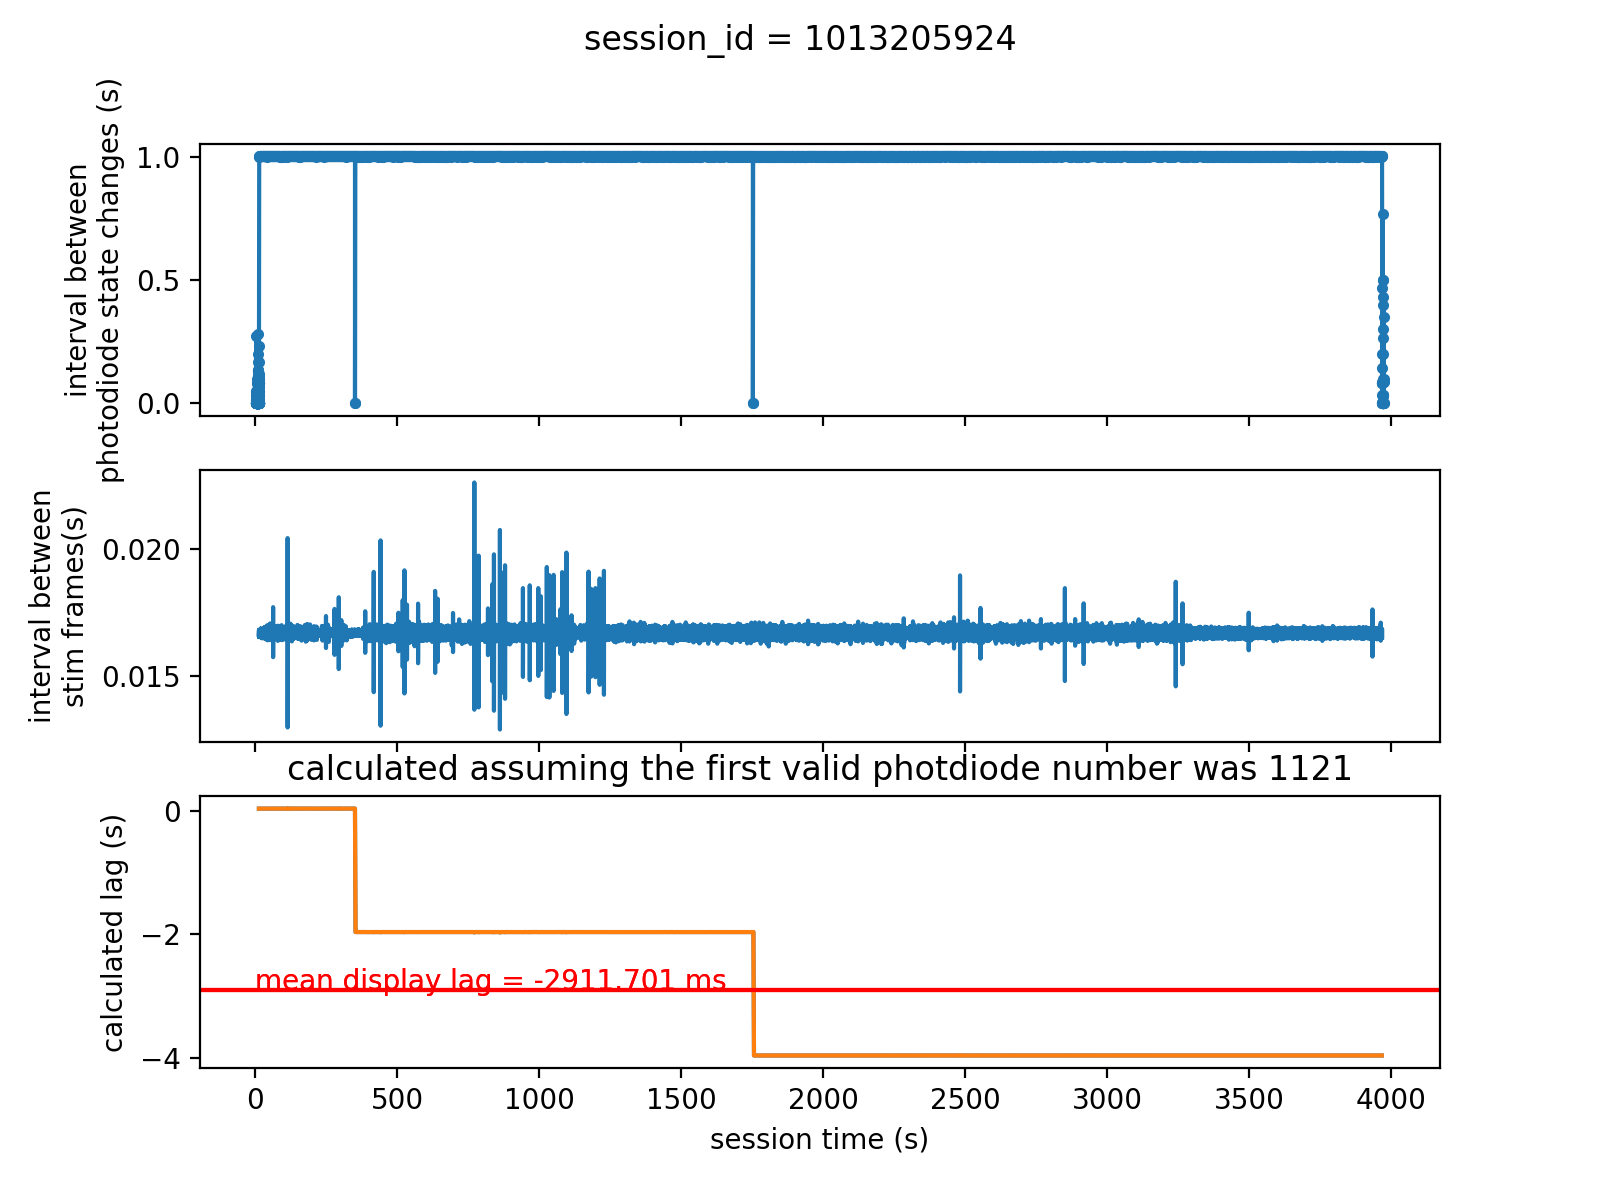

In [308]:
fig = plot_sync_data(session_id, sync_vsync_times, photodiode_all, first_idx)

In [242]:
photodiode_all[first_idx:last_idx+2]

array([   6.00474,    7.00329,    8.00632, ..., 4504.70528, 4505.70834,
       4506.70692])

In [245]:
photodiode_all[:15]

array([ 1.96688,  1.98309,  2.06848,  5.50205,  5.58547,  5.67112,
        5.75226,  5.83792,  5.91907,  6.00474,  7.00329,  8.00632,
        9.00491, 10.00796, 11.00653])

In [202]:
len(pd1)

4497

<IPython.core.display.Javascript object>


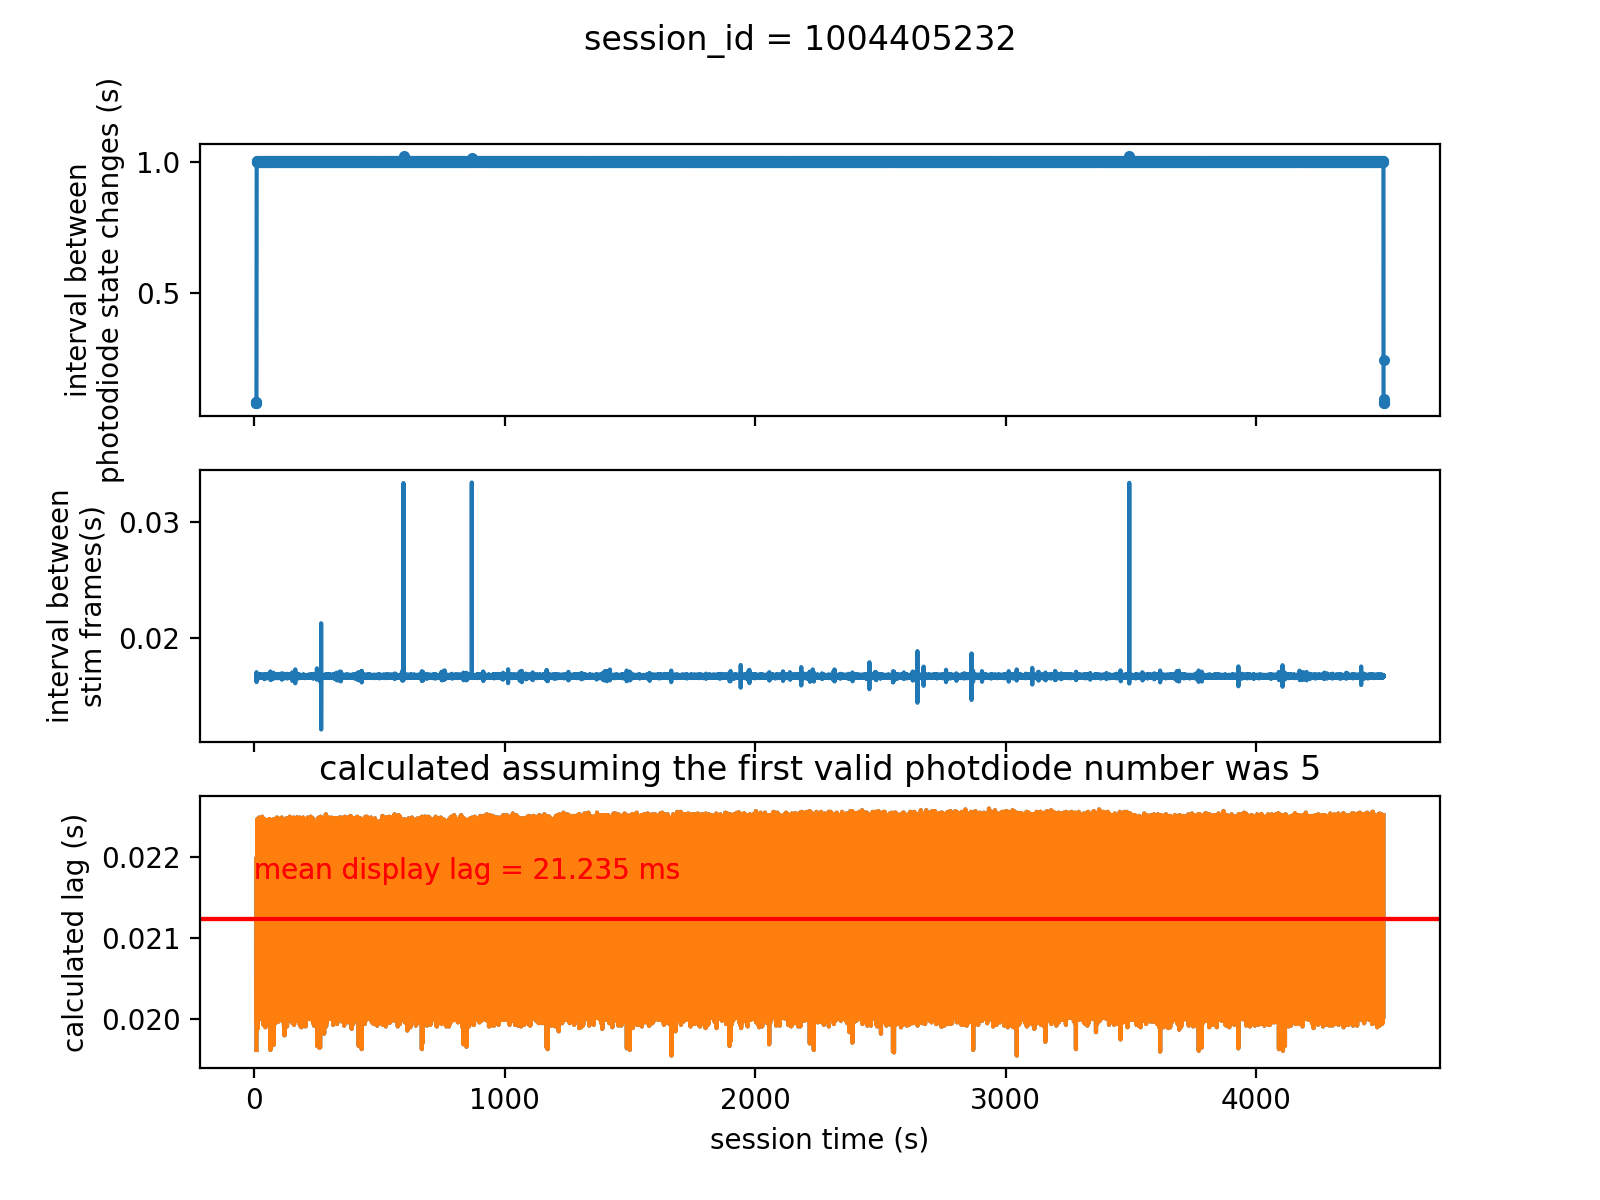

In [194]:
session = session_df.loc[0]

sync_vsync_times, photodiode_all = extract_from_sync(session)
pd_df = get_lags_at_all_pd_starts(sync_vsync_times, photodiode_all)
optimal_first_pd = pd_df['first_valid_pd'].loc[pd_df['std'].argmin()]
fig = plot_sync_data(session['exp_id'], sync_vsync_times, photodiode_all,optimal_first_pd)

In [175]:
load_output_json(session)

{'allensdk_version': '1.4.0',
 'date': '2020-01-24 02:37:28.598722',
 'experiment_id': 1002314807,
 'output_h5_path': '/allen/programs/braintv/production/visualbehavior/prod4/specimen_951667115/ophys_session_1001860744/ophys_experiment_1002314807/1002314807_time_synchronization.h5',
 'ophys_delta': 2,
 'stim_delta': 0,
 'stim_delay': 0.0351,
 'eye_delta': 0,
 'behavior_delta': 0}

<IPython.core.display.Javascript object>


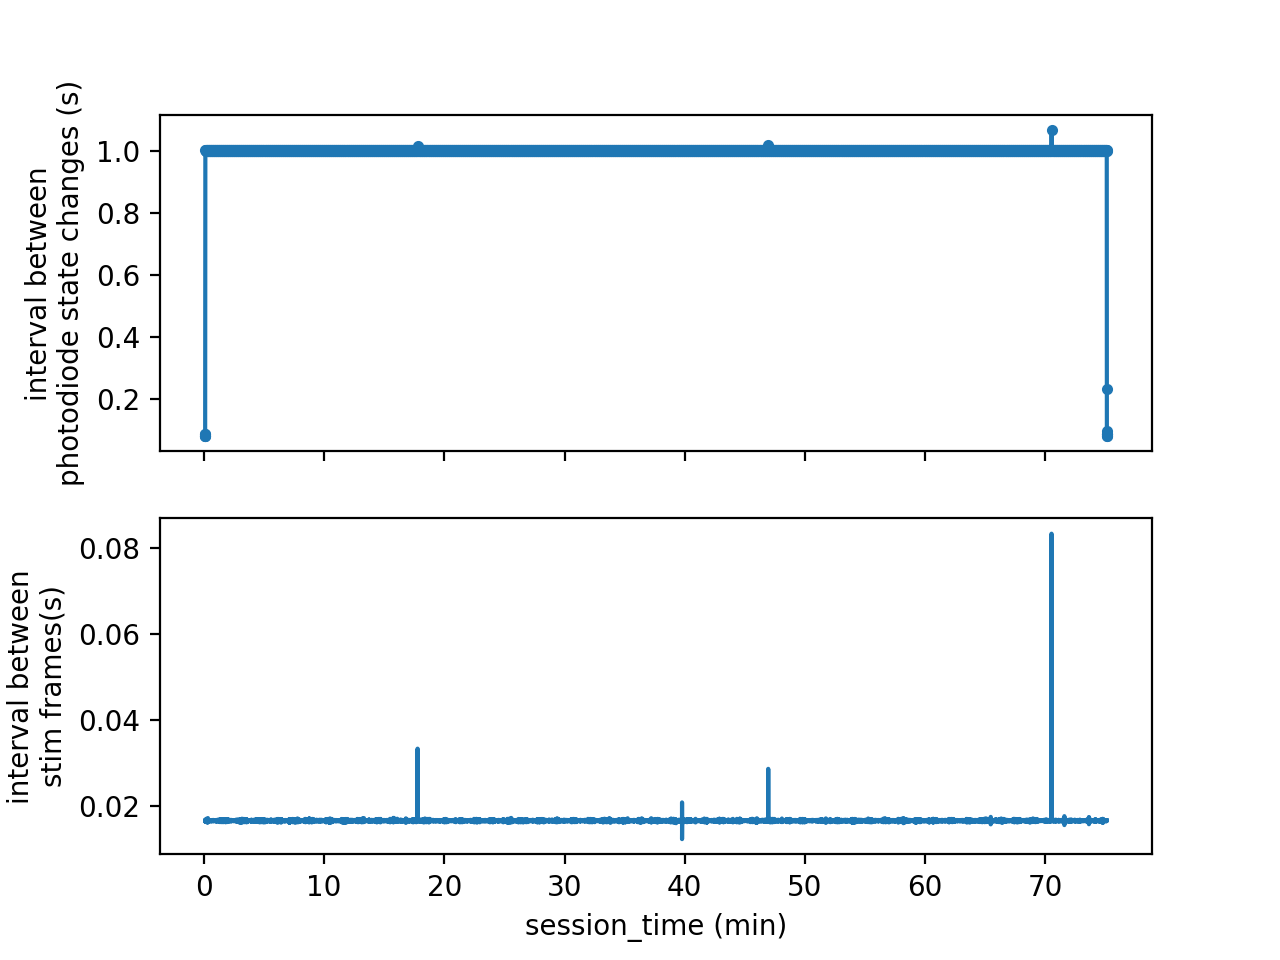

Text(0.5, 0, 'session_time (min)')

In [98]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(photodiode_all[1:]/60.,np.diff(photodiode_all),marker='.')

ax[0].set_ylabel('interval between\nphotodiode state changes (s)')

ax[1].plot(sync_vsync_times[1:]/60.,np.diff(sync_vsync_times))
ax[1].set_ylabel('interval between\nstim frames(s)')
ax[1].set_xlabel('session_time (min)')

In [99]:
first_valid_pd = 5
lag = np.empty(len(sync_vsync_times[::60]))
key_frames = sync_vsync_times[::60]
for idx,key_frame in enumerate(key_frames):
    lag[idx]=photodiode_all[first_valid_pd:][idx]-key_frame

In [100]:
pd.Series(lag).describe()

count    4498.000000
mean        0.021203
std         0.001195
min         0.019480
25%         0.020030
50%         0.020990
75%         0.022420
max         0.022530
dtype: float64

In [101]:
pd_start_df = []
for first_valid_pd in range(10):
    lag = np.empty(len(sync_vsync_times[::60]))
    key_frames = sync_vsync_times[::60]
    for idx,key_frame in enumerate(key_frames):
        lag[idx]=photodiode_all[first_valid_pd:][idx]-key_frame
    this_entry = dict(pd.Series(lag).describe())
    this_entry.update({'first_valid_pd':first_valid_pd})
    pd_start_df.append(this_entry)
pd_start_df = pd.DataFrame(pd_start_df)
pd_start_df

,count,mean,std,min,25%,50%,75%,max,first_valid_pd
0,4498.0,-4.979929,0.101451,-5.05078,-4.98405,-4.983990,-4.98166,-0.39492,0
1,4498.0,-3.980111,0.074933,-4.04997,-3.98323,-3.983170,-3.98085,-0.31395,1
2,4498.0,-2.980088,0.051224,-3.04915,-2.98241,-2.982355,-2.98003,-0.22812,2
3,4498.0,-1.979862,0.030630,-2.04830,-1.98160,-1.981530,-1.97922,-0.14716,3
4,4498.0,-0.979431,0.013784,-1.04506,-0.98078,-0.980720,-0.97840,-0.06131,4
5,4498.0,0.021203,0.001195,0.01948,0.02003,0.020990,0.02242,0.02253,5
6,4498.0,1.021871,0.011567,0.25357,1.02085,1.022705,1.02323,1.08756,6
7,4498.0,2.022335,0.027658,0.33934,2.02167,2.023515,2.02405,2.09079,7
8,4498.0,3.022594,0.047667,0.42038,3.02248,3.024375,3.02486,3.09161,8
9,4498.0,4.022650,0.070878,0.50616,4.02330,4.025160,4.02568,4.09243,9


<IPython.core.display.Javascript object>


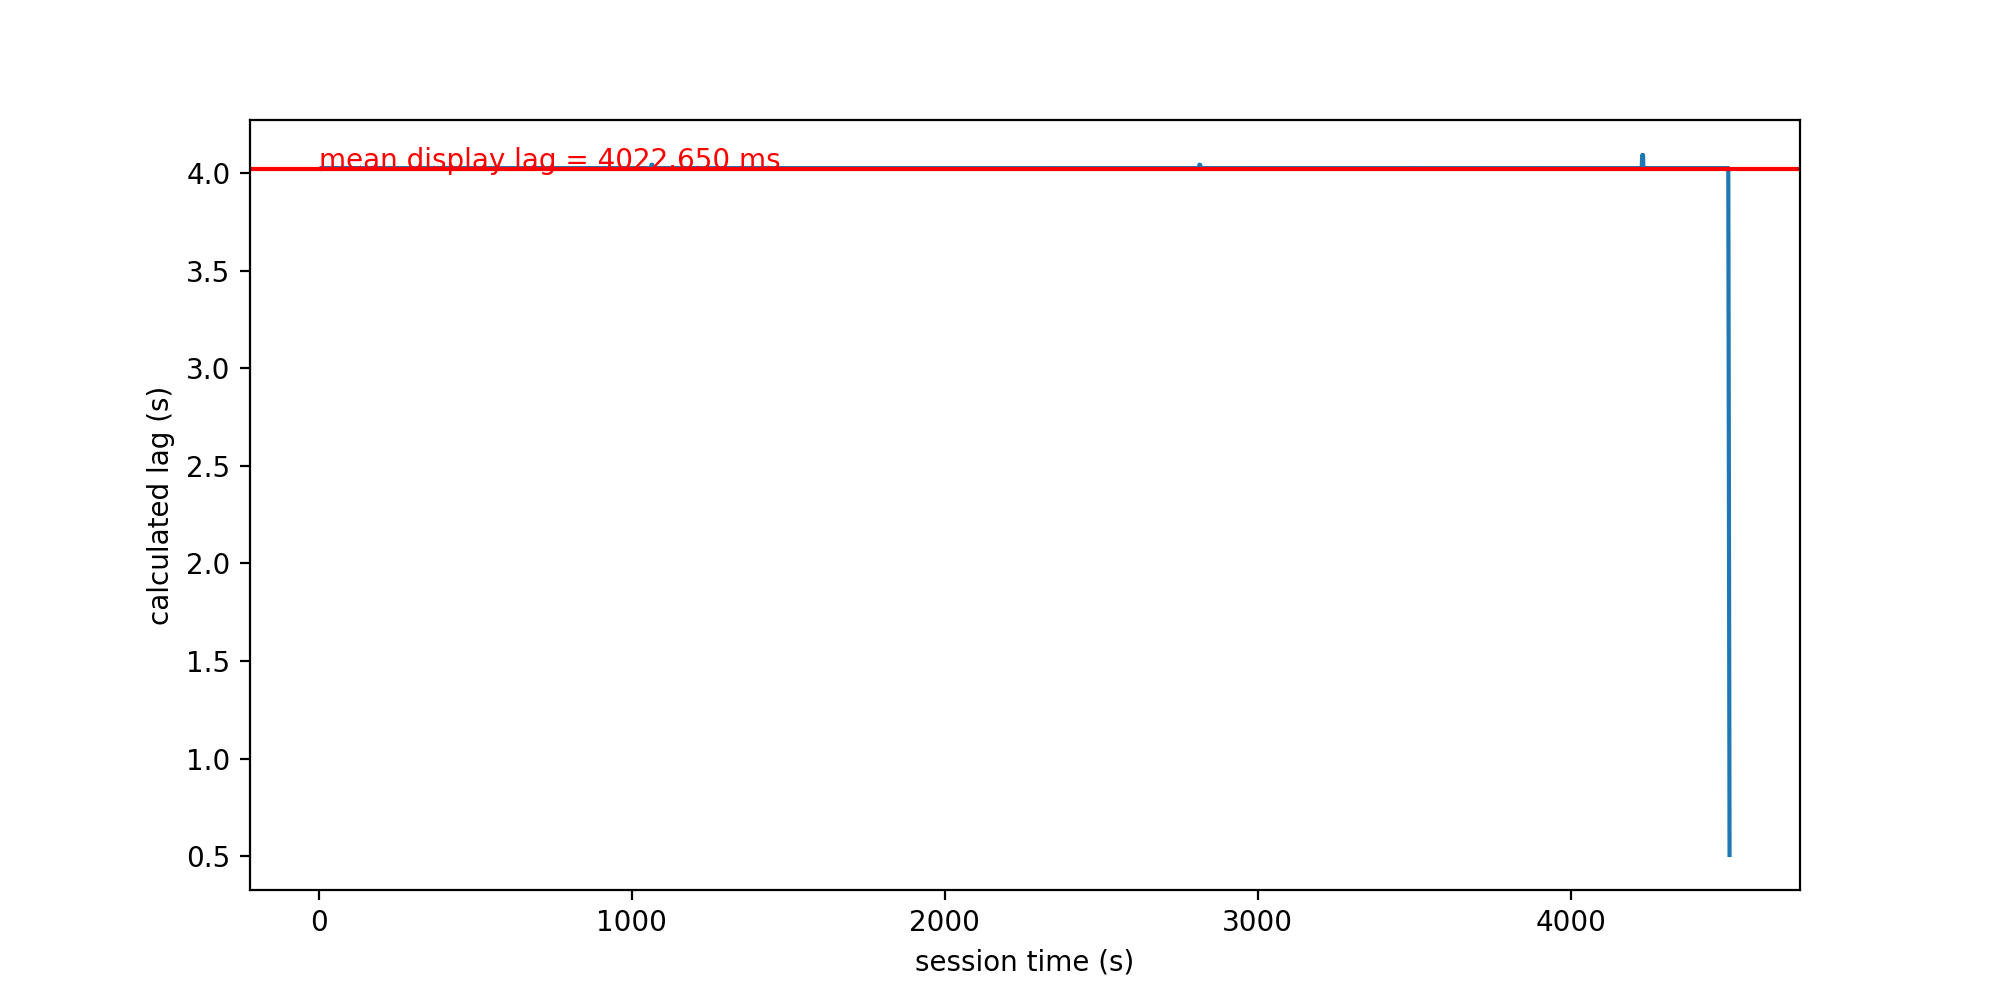

Text(0, 4.023150251222765, 'mean display lag = 4022.650 ms')

In [102]:

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(sync_vsync_times[::60],lag)

ax.set_xlabel('session time (s)')
ax.set_ylabel('calculated lag (s)')
ax.axhline(np.mean(lag),color='r')
ax.text(0,np.mean(lag)+0.0005,'mean display lag = {:.3f} ms'.format(1000*np.mean(lag)),color='r')

In [60]:
print('len(stim_vsync_falling): {}'.format(len(sync_data['stim_vsync_falling'])))

expected_pd_events = int(np.floor(len(sync_data['stim_vsync_falling'])/60))
print('expected number of photodiode events: {}'.format(expected_pd_events))

actual_pd_events = len(sync_data['stim_photodiode_rising']) + len(sync_data['stim_photodiode_falling'])
print('actual number of photodiode events (rising and falling): {}'.format(actual_pd_events))

len(stim_vsync_falling): 269835
expected number of photodiode events: 4497
actual number of photodiode events (rising and falling): 4510


In [48]:
photodiode_risetimes = sync_data.get_rising_edges('stim_photodiode')/sample_freq
photodiode_falltimes = sync_data.get_falling_edges('stim_photodiode')/sample_freq
photodiode_all = np.sort(np.hstack((photodiode_risetimes,photodiode_falltimes)))

269835

In [35]:
d

{'allensdk_version': '1.4.0',
 'date': '2020-02-01 06:28:54.698704',
 'experiment_id': 1004405232,
 'output_h5_path': '/allen/programs/braintv/production/visualbehavior/prod4/specimen_947329063/ophys_session_1004238538/ophys_experiment_1004405232/1004405232_time_synchronization.h5',
 'ophys_delta': 2,
 'stim_delta': 0,
 'stim_delay': 0.0351,
 'eye_delta': 0,
 'behavior_delta': 0}

269835